In [ ]:
import torch

In [ ]:
#Check for GPU
gpu = torch.cuda.is_available()
device = 'cuda' if gpu == True else 'cpu'
print('Using device:', device)

Using device: cuda


In [ ]:
#Connecting Google Colab with Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Directories path
train_dir = "/content/drive/MyDrive/Oranges Dataset/Train"
test_dir = "/content/drive/MyDrive/Oranges Dataset/Test"

In [ ]:
#Dataset image Transformation
import torchvision
from torchvision import transforms, datasets

image_size = 256
resize_transform = transforms.Compose([transforms.Resize((image_size,image_size)),
                                       transforms.ToTensor()])

training_set = datasets.ImageFolder(root = train_dir, transform = resize_transform)
testing_set = datasets.ImageFolder(root = test_dir, transform = resize_transform)


In [ ]:
#Data Loading
from torch.utils.data import DataLoader

train_loader = DataLoader(training_set, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(testing_set, batch_size=16, shuffle=True, num_workers=2)


In [ ]:
image, label =  next(iter(train_loader))
print(label)

tensor([1, 3, 3, 0, 1, 3, 2, 1, 1, 3, 0, 1, 1, 3, 1, 1])


Labels: tensor([1, 3, 3, 0, 1, 3, 2, 1, 1, 3, 0, 1, 1, 3, 1, 1])
Training set size:  321
Test set size:  80


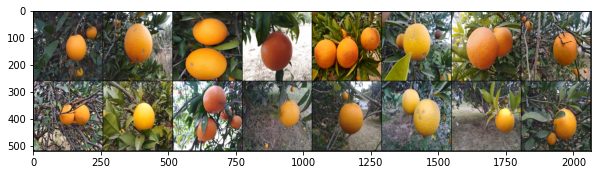

In [ ]:
#Data Visualization

import matplotlib.pyplot as plt
import numpy as np

grid = torchvision.utils.make_grid(image, nrow=8)
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(grid, (1,2,0)))
print('Labels:', label)
print('Training set size: ', len(training_set))
print('Test set size: ', len(testing_set))

#grid = torchvision.utils.make_grid(image, nrow=8)
#plt.figure(figsize=(10,10))
#plt.imshow(np.transpose(grid, (1,2,0)))
#print('Labels:', label)


In [ ]:
layer_dims = [image_size*image_size*3, 4]
print(layer_dims)
#print(device)

[196608, 4]


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, D_in,D_out):
        super(Net, self).__init__()
        
        self.layer1 = nn.Linear(D_in, 500)
        self.layer2 = nn.Linear(500, 350)
        self.layer3 = nn.Linear(350, 200)
        self.layer4 = nn.Linear(200, 50)
        self.layer5 = nn.Linear(50, D_out)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = self.layer5(x)
        return F.log_softmax(x, dim=1)  

In [ ]:
classes = ['Keenu', 'Musami', 'Red Blood', 'Shakri']
test_loss = 0
correct_test = 0
class_correct = list(0. for i in range(4))
class_total = list(0. for i in range(4))
#print(device)

In [ ]:
# Nueral Network Summary
net = Net(layer_dims[0],layer_dims[1]).cuda()
net

Net(
  (layer1): Linear(in_features=196608, out_features=500, bias=True)
  (layer2): Linear(in_features=500, out_features=350, bias=True)
  (layer3): Linear(in_features=350, out_features=200, bias=True)
  (layer4): Linear(in_features=200, out_features=50, bias=True)
  (layer5): Linear(in_features=50, out_features=4, bias=True)
)

In [ ]:
# Loss Function and Optimizer
import torch.optim as optim
loss_criterion = nn.CrossEntropyLoss()
loss_criterion = loss_criterion.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.000005 , weight_decay = 1e-5)
print(device)

cuda


In [ ]:
useful_stuff ={'training_loss': [], 'training_accuracy': [], 'test_accuracy': []}
for epoch in range(150): 
    correct_training = 0
    for data in train_loader:  
        x, y = data
        x = x.to(device)
        y = y.to(device) 
        net.zero_grad()  
        output = net(x.view(-1,  layer_dims[0]))
        output = output.to(device) 
        loss = loss_criterion(output, y)  
        loss.backward()  
        optimizer.step() 
        useful_stuff['training_loss'].append(loss.data.item())
        _, label = torch.max(output, 1)
        correct_training += (label == y).sum().item()
    accuracy_training = 100 * (correct_training / len(training_set)) 
    print('Epoch: {}  Training Accuracy: {}'.format(epoch, accuracy_training))
    useful_stuff['training_accuracy'].append(accuracy_training)

Epoch: 0  Training Accuracy: 43.613707165109034
Epoch: 1  Training Accuracy: 46.10591900311526
Epoch: 2  Training Accuracy: 54.51713395638629
Epoch: 3  Training Accuracy: 43.925233644859816
Epoch: 4  Training Accuracy: 51.4018691588785
Epoch: 5  Training Accuracy: 53.58255451713395
Epoch: 6  Training Accuracy: 50.155763239875384
Epoch: 7  Training Accuracy: 53.271028037383175
Epoch: 8  Training Accuracy: 60.43613707165109
Epoch: 9  Training Accuracy: 56.38629283489096
Epoch: 10  Training Accuracy: 56.38629283489096
Epoch: 11  Training Accuracy: 57.009345794392516
Epoch: 12  Training Accuracy: 62.928348909657316
Epoch: 13  Training Accuracy: 66.35514018691589
Epoch: 14  Training Accuracy: 63.55140186915887
Epoch: 15  Training Accuracy: 64.17445482866043
Epoch: 16  Training Accuracy: 67.601246105919
Epoch: 17  Training Accuracy: 68.22429906542055
Epoch: 18  Training Accuracy: 66.35514018691589
Epoch: 19  Training Accuracy: 68.22429906542055
Epoch: 20  Training Accuracy: 67.28971962616822

In [2]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        x, y = data
        x = x.to(device)
        y = y.to(device)
        output = net(x.view(-1,layer_dims[0]))
        output = output.to(device)
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
              correct += 1
            total += 1

print("Accuracy: ", round(correct/total, 2))


Accuracy: 0.81
